In [110]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from math import sqrt

Function that adds lagged values to the dataframe

In [111]:
def gen_lags(df,lags):
    for i in range(lags):
        new_series = df['Close'].shift(i+1)
        df.insert(len(df.columns),'lag'+str(i+1),new_series)
        df.dropna(inplace = True)
    return df

In [112]:
data = pd.read_csv("data/PepsiCo.csv")['Close']
print(data)
data = pd.DataFrame(data)
data = gen_lags(data,3)

0       143.080002
1       143.149994
2       143.179993
3       143.205002
4       143.255005
           ...    
2575    142.779999
2576    142.774994
2577    142.792496
2578    142.789993
2579    142.794998
Name: Close, Length: 2580, dtype: float64


In [113]:
train_size = int(len(data) * 0.9)
train, test = data[:train_size], data[train_size:]
X_train,y_train = train.drop(['Close'],axis=1), train['Close']
X_test,y_test = test.drop(['Close'],axis=1), test['Close']

As data needs to be rescaled for SVM to work better, we will apply MinMaxScaler

In [114]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()
X_train_scaled = scaler1.fit_transform(X_train)
X_test_scaled = scaler1.transform(X_test)
y_train_scaled = scaler2.fit_transform(y_train.values.reshape(-1,1))

In [121]:
from sklearn import svm 
regressor = svm.SVR()

In [122]:
regressor.fit(X_train,y_train)

SVR()

In [117]:
predicts = regressor.predict(X_test)
predicts = scaler2.inverse_transform(predicts.reshape(-1, 1))

In [118]:
nindex = np.arange(len(y_test))
predicts = pd.Series(predicts.flatten())
predicts.index = nindex
y_test = pd.Series(y_test)
y_test.index = nindex

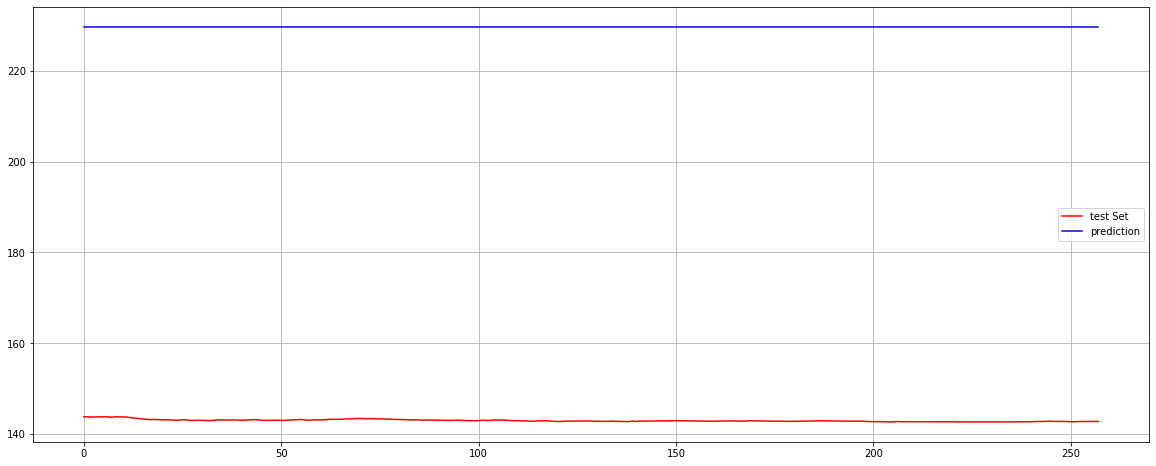

In [119]:
plt.figure(figsize=(20, 8))
plt.grid(True)
plt.plot( y_test , color='red', label="test Set")
plt.plot(predicts, color='blue', label="prediction")
plt.legend()
plt.show()

The results is obviously unsatisfactory.

This is an example of how scaling can actually damage the method's ability to model adequatly the time series. First of all, there is not much sense in scaling variables in our case, as all of them are of the same scale. Secondly, when there is very little variation in data, and it is caused primarily by noise (which is very typical of financial data), scaling can affect the performance negatively. 

Now, let's do the same thing but without scaling

In [140]:
data = pd.read_csv("data/PepsiCo.csv")['Close']
data = pd.DataFrame(data)
data = gen_lags(data,3)

In [141]:
train_size = int(len(data) * 0.9)
train, test = data[:train_size], data[train_size:]
X_train,y_train = train.drop(['Close'],axis=1), train['Close']
X_test,y_test = test.drop(['Close'],axis=1), test['Close']

In [142]:
regressor = svm.SVR(C=1, epsilon = 0.01)
regressor.fit(X_train,y_train)

SVR(C=1, epsilon=0.01)

In [143]:
predicts = regressor.predict(X_test)
nindex = np.arange(len(y_test))
predicts = pd.Series(predicts.flatten())
predicts.index = nindex
y_test = pd.Series(y_test)
y_test.index = nindex

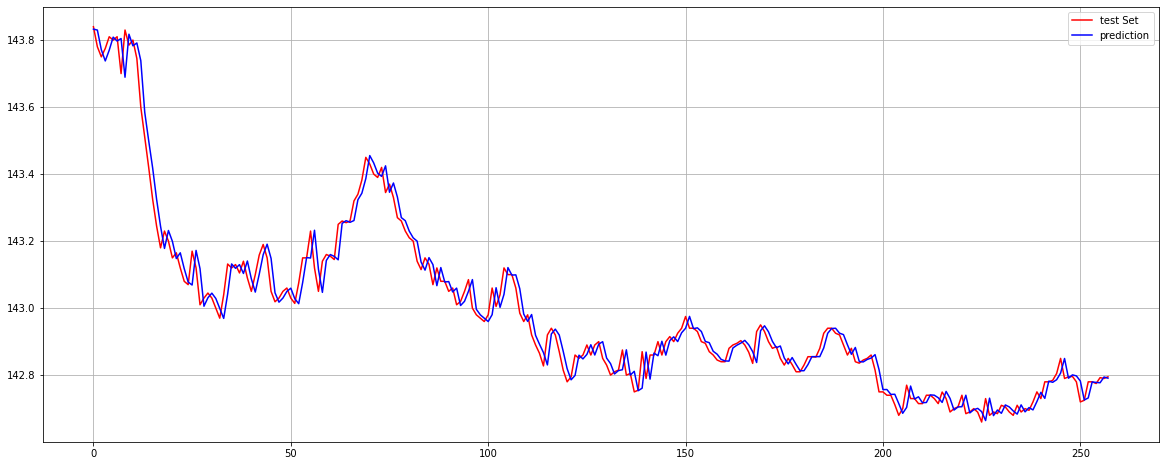

In [144]:
plt.figure(figsize=(20, 8))
plt.grid(True)
plt.plot( y_test , color='red', label="test Set")
plt.plot(predicts, color='blue', label="prediction")
plt.legend()
plt.show()

The problem inherent in this method of prediction is that the prediction graph will always look like the real one just shifted to the right. This happens exactly because our model is able to catch changes (upward or downward shift) only after the changing values is read as an input. In other words, out model is nearly always late when it predicts any substantial change

In [145]:
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [146]:
sqrt(mean_squared_error(y_test,predicts))

0.042089047258261375

In [147]:
mda(y_test,predicts)

0.9922480620155039

In [148]:
mean_absolute_percentage_error(y_test,predicts)

0.02226352521371169

To choose the optimal hyperparameters, we can use GridSearchCV from sklearn

In [32]:
param = {'kernel' : ('linear', 'rbf','sigmoid'), 'C':[0.5,1,5,7], 'epsilon':[0.01,0.1,1,5,10],'gamma':[5,1,0.1,0.01,0.001]},


grids = GridSearchCV(regressor,param,cv=5,n_jobs = -1)

%time grids.fit(X_train,y_train)

In [ ]:
grids.best_params_

To choose the optimal number of lagged values, we can use the following function

In [138]:
def lags_search(datapath, lags):
    mean_squared_error = 10000000
    lag = 0
    for i in lags:
        data = pd.read_csv(datapath)['Close']
        data = pd.DataFrame(data)
        data = gen_lags(data,i)
        train_size = int(len(data) * 0.9)
        train, test = data[:train_size], data[train_size:]
        X_train,y_train = train.drop(['Close'],axis=1), train['Close']
        X_test,y_test = test.drop(['Close'],axis=1), test['Close']
        regressor = svm.SVR(kernel = 'linear',cache_size=1000, C=1,gamma=5)
        regressor.fit(X_train,y_train)
        predicts = regressor.predict(X_test)
        error = mean_squared_error(y_test,predicts)
        if (error < mean_squared_error):
            lag = i
            mean_squared_error = error
        print(i)
        print(error)
    return lag

In [ ]:
experiment("PepsiCo.csv", [2,3,4,5,7,10,13])

Finally, we can write a function to perform all this steps. As it can take **really long** (even for very small datasets) for the function choosing the optimal number of lags to complete, I will leave the choice of the number of laggs to the user 

In [156]:
def experiment():
    datapath = str(input("Enter the path to the dataset"))
    data = pd.read_csv(datapath)['Close']
    data = pd.DataFrame(data)
    lags = int(input("How many lagged values will be in our model"))
    data = gen_lags(data,lags)
    split = float(input("Enter the split fraction"))
    train_size = int(len(data) * split)
    train, test = data[:train_size], data[train_size:]
    X_train,y_train = train.drop(['Close'],axis=1), train['Close']
    X_test,y_test = test.drop(['Close'],axis=1), test['Close']
    regressor = svm.SVR(C=1, epsilon = 0.01)
    regressor.fit(X_train,y_train)
    predicts = regressor.predict(X_test)
    
    #some minor manipulations with indeces
    nindex = np.arange(len(y_test))
    predicts = pd.Series(predicts.flatten())
    predicts.index = nindex
    y_test = pd.Series(y_test)
    y_test.index = nindex
    
    plt.figure(figsize=(20, 8))
    plt.grid(True)
    plt.plot( y_test , color='red', label="test Set")
    plt.plot(predicts, color='blue', label="prediction")
    plt.legend()
    plt.show()
    
    print("Root Mean Squared Error:", sqrt(mean_squared_error(y_test,predicts)))
    

Enter the path to the dataset/Users/emilakopyan/Downloads/Apple.csv
How many lagged values will be in our model3
Enter the split fraction0.9


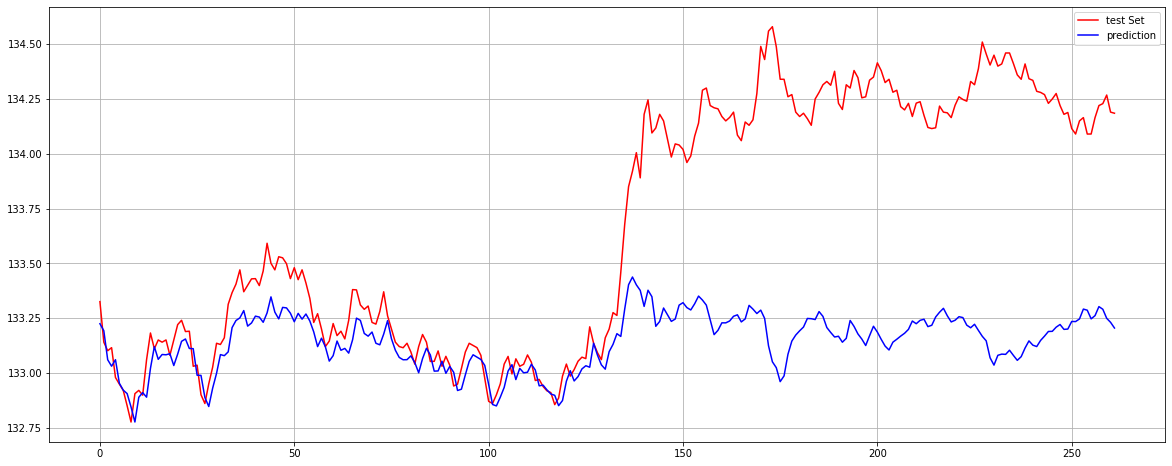

Root Mean Squared Error: 0.7284155509131597


In [157]:
experiment()